In [ ]:
import pandas as pd

df = pd.read_csv('/content/df9.csv')
print(df.shape)
print(df.columns)

(19534, 86)
Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'store_status', 'c_nightlife',
       'c_cafes', 'c_brunch', 'c_sandwich', 'c_american_trad',
       'c_american_new', 'c_italian', 'c_burgers', 'c_mexican', 'c_seafood',
       'c_fastfood', 'c_asian_fusion', 'c_bakeries', 'c_dietary', 'c_other',
       'a_full_expansion', 'a_reservation_model', 'a_parking_space',
       'a_outdoor_seating', 'a_price_range', 'a_good_for_group',
       'a_good_for_kids', 'a_alcohol', 'a_has_tv', 'a_noise_level',
       'a_ambience', 'a_happy_hour', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'mon_morning',
       'mon_afternoon', 'mon_evening', 'mon_night', 'tue_morning',
       'tue_afternoon', 'tue_evening', 'tue_night', 'wed_morning',
       'wed_afternoon', 'wed_evening', 'wed_night', 'thu_morning',
       'thu_aft

In [ ]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [ ]:
exclude_cols = [

    # basic restaurant information
    'business_id', 'name', 'attributes', 'categories', 'hours',

    # location information
    'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',

    # business hours information
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',

            ]

df = df.drop(columns=exclude_cols)

In [ ]:
# bool 형태 데이터들 object -> int

# 변환할 컬럼 리스트
bool_cols = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']

# 문자열을 0/1로 변환하는 함수
def str_to_int_bool(x):
    if pd.isna(x):
        return np.nan   # 결측값은 그대로 유지 (원하면 0으로 바꿔도 됨)
    elif str(x).strip().lower() == 'true':
        return 1
    elif str(x).strip().lower() == 'false':
        return 0
    else:
        return np.nan

# 각 컬럼에 적용
for col in bool_cols:
    df[col] = df[col].apply(str_to_int_bool).astype('Int64')  # pandas nullable int형

In [ ]:
# 노이즈 레벨 맵핑

# quiet < average < loud < very_loud

noise_mapping = {
    'quiet': 0,
    'average': 1,
    'loud': 2,
    'very_loud': 3
}

df['a_noise_level'] = df['a_noise_level'].map(noise_mapping)

In [ ]:
# 결측치 = 0(해당사항 없음)으로

cols_bool = ['a_outdoor_seating', 'a_good_for_group', 'a_good_for_kids', 'a_has_tv', 'a_happy_hour']
df[cols_bool] = df[cols_bool].fillna(0).astype(int)

In [ ]:
# a_alcohol 결측치 채우기
df['a_alcohol'] = np.where(
    df['a_alcohol'].isna(),                        # ① 결측치인 행만 선택
    np.where(df['c_nightlife'] == 1, 'full_bar', 'none'),  # ② nightlife면 full_bar, 아니면 none
    df['a_alcohol']                                 # ③ 기존값 유지
)

In [ ]:
# 결측치일경우 unknown

df['a_ambience'] = df['a_ambience'].fillna('unknown')

In [ ]:
# 1️⃣ 카테고리 컬럼 리스트
cat_cols = [
    'c_nightlife', 'c_cafes', 'c_brunch', 'c_sandwich', 'c_american_trad', 'c_american_new',
    'c_italian', 'c_burgers', 'c_mexican', 'c_seafood', 'c_fastfood',
    'c_asian_fusion', 'c_bakeries', 'c_dietary', 'c_other'
]

# 2️⃣ 각 카테고리별 중앙값 계산
cat_medians = {
    c: df.loc[df[c] == 1, 'a_price_range'].median()
    for c in cat_cols
}

# 3️⃣ 결측치 채우는 함수 정의
def fill_price(row):
    if pd.notna(row['a_price_range']):
        return row['a_price_range']

    # 해당 행에서 속한 카테고리 찾기
    cats = [c for c in cat_cols if row[c] == 1]

    # 해당 카테고리들의 중앙값 수집
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]

    if len(vals) == 0:
        # 어떤 카테고리에도 속하지 않으면 전체 중앙값 사용
        return df['a_price_range'].median()
    elif len(vals) == 1:
        # 카테고리 1개면 그 카테고리의 중앙값
        return vals[0]
    else:
        # 카테고리 2개 이상이면 중앙값들의 평균
        return np.mean(vals)

# 4️⃣ 결측값 채우기 적용
df['a_price_range'] = df.apply(fill_price, axis=1)

In [ ]:
# a_noise_level 결측치 채우기

# 1️⃣ 각 카테고리별 중앙값 계산
cat_medians = {
    c: df.loc[df[c] == 1, 'a_noise_level'].median()
    for c in cat_cols
}

# 2️⃣ 결측치 채우는 함수
def fill_noise(row):
    if pd.notna(row['a_noise_level']):
        return row['a_noise_level']

    cats = [c for c in cat_cols if row[c] == 1]
    vals = [cat_medians[c] for c in cats if not np.isnan(cat_medians[c])]

    if len(vals) == 0:
        # 전체 중앙값으로 채우기
        val = df['a_noise_level'].median()
    elif len(vals) == 1:
        val = vals[0]
    else:
        val = np.mean(vals)

    # 반올림 후 정수형 변환
    return round(val)

# 3️⃣ 결측값 채우기 적용
df['a_noise_level'] = df.apply(fill_noise, axis=1).astype(int)

In [ ]:
df.isna().sum().sort_values(ascending=False).head(10)

,0
stars,0
review_count,0
is_open,0
store_status,0
c_nightlife,0
c_cafes,0
c_brunch,0
c_sandwich,0
c_american_trad,0
c_american_new,0


In [ ]:
for col in df.select_dtypes('bool').columns:
    df[col] = df[col].astype(int)

In [ ]:
cat_cols = ['store_status', 'a_alcohol', 'a_ambience']
df = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, drop_first=True)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [ ]:
threshold = df["reliability_score"].mean()
y = (df["reliability_score"] > threshold).astype(int)
X = df.drop(columns=["reliability_score"], errors="ignore")

In [ ]:
numeric_features = X.select_dtypes(include=["int64","float64"]).columns
categorical_features = X.select_dtypes(include=["object","category","bool"]).columns

In [ ]:
if len(categorical_features) > 0:
    X[categorical_features] = X[categorical_features].astype(str)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_features),
    ("cat", categorical_pipe, categorical_features)
])

In [ ]:
clf = Pipeline([
    ("prep", preprocess),
    ("model", LGBMClassifier(random_state=42))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 7571, number of negative: 8056
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1210
[LightGBM] [Info] Number of data points in the train set: 15627, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484482 -> initscore=-0.062092
[LightGBM] [Info] Start training from score -0.062092


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
print("✅ Accuracy:", accuracy_score(y_test, pred))
print("✅ ROC-AUC:", roc_auc_score(y_test, proba))
print("\nClassification Report:\n", classification_report(y_test, pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

✅ Accuracy: 0.8003583312004096
✅ ROC-AUC: 0.8838235363548661

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81      2014
           1       0.79      0.80      0.80      1893

    accuracy                           0.80      3907
   macro avg       0.80      0.80      0.80      3907
weighted avg       0.80      0.80      0.80      3907

Confusion Matrix:
 [[1614  400]
 [ 380 1513]]


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1),
    "XGBoost": XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8,
        eval_metric="logloss", random_state=42
    ),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [ ]:
results = []
for name, model in models.items():
    print("="*60)
    print(f"▶ 모델: {name}")

    clf = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])

    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    proba = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, proba)

    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print(f"✅ ROC-AUC: {roc_auc:.4f}")
    print(confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=4))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1": f1,
        "ROC-AUC": roc_auc
    })

▶ 모델: LogisticRegression
✅ Accuracy: 0.7909
✅ F1-Score: 0.7794
✅ ROC-AUC: 0.8672
[[1647  367]
 [ 450 1443]]
              precision    recall  f1-score   support

           0     0.7854    0.8178    0.8013      2014
           1     0.7972    0.7623    0.7794      1893

    accuracy                         0.7909      3907
   macro avg     0.7913    0.7900    0.7903      3907
weighted avg     0.7911    0.7909    0.7907      3907

▶ 모델: RandomForest
✅ Accuracy: 0.8060
✅ F1-Score: 0.7955
✅ ROC-AUC: 0.8850
[[1675  339]
 [ 419 1474]]
              precision    recall  f1-score   support

           0     0.7999    0.8317    0.8155      2014
           1     0.8130    0.7787    0.7955      1893

    accuracy                         0.8060      3907
   macro avg     0.8065    0.8052    0.8055      3907
weighted avg     0.8063    0.8060    0.8058      3907

▶ 모델: XGBoost
✅ Accuracy: 0.8080
✅ F1-Score: 0.7986
✅ ROC-AUC: 0.8871
[[1670  344]
 [ 406 1487]]
              precision    recall  f1-s

In [ ]:
print("\n=== 📊 모델 성능 비교 (신뢰점수)===")
results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
print(results_df)


=== 📊 모델 성능 비교 (신뢰점수)===
                Model  Accuracy        F1   ROC-AUC
2             XGBoost  0.808037  0.798604  0.887130
1        RandomForest  0.805989  0.795467  0.884992
3            LightGBM  0.800358  0.795060  0.883824
0  LogisticRegression  0.790888  0.779368  0.867186


In [ ]:
import shap
prep = clf.named_steps["prep"]
model = clf.named_steps["model"]

In [ ]:
X_test_transformed = prep.transform(X_test)

In [ ]:
explainer = shap.Explainer(model)  # LightGBM 자동 인식
shap_values = explainer(X_test_transformed)

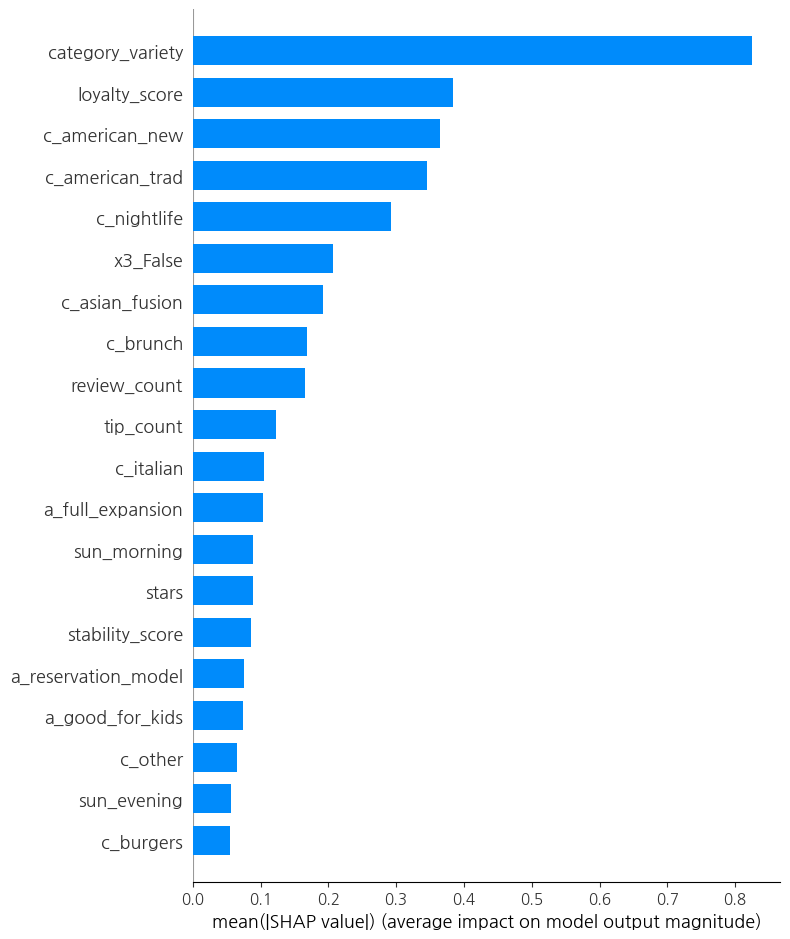

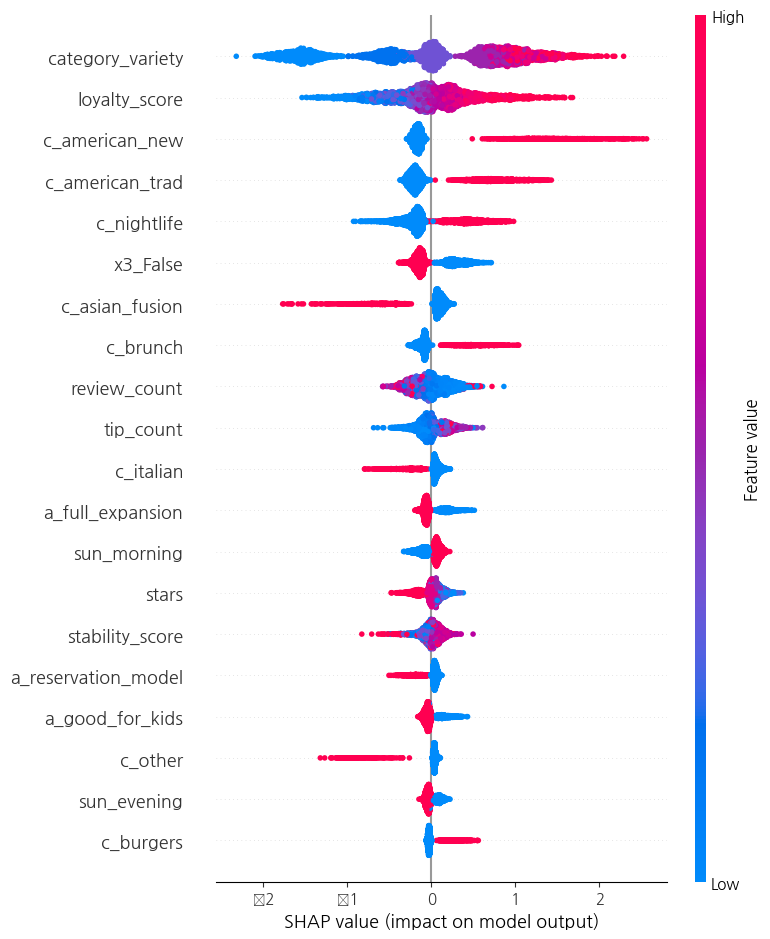

In [ ]:
shap.summary_plot(shap_values, feature_names=np.concatenate([
    prep.named_transformers_["num"].get_feature_names_out(),
    prep.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out()
]), plot_type="bar")

shap.summary_plot(shap_values, feature_names=np.concatenate([
    prep.named_transformers_["num"].get_feature_names_out(),
    prep.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out()
]))